# Investigating community language using wordclouds
We move on to analyse the communities based on the words that are used in their posts.



In [1]:
#Import relevant libraries
import json
import networkx as nx
from netwulf import visualize, draw_netwulf
import netwulf as nw
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import ast
from itertools import product
from collections import Counter
import random
from wordcloud import WordCloud
from tqdm import tqdm
from joblib import Parallel, delayed
import warnings  
from collections import Counter
import re
import nltk
from nltk.corpus import stopwords
from itertools import product
from itertools import product
from sklearn.feature_extraction.text import TfidfVectorizer
warnings.filterwarnings("ignore", category=FutureWarning)
import html

## Textual Cleaning

In [ ]:
G_All_communities = nx.read_gml("FINAL_reddit_graph_with_louvain_communities.gml", label=None)

In [3]:
# convert G_All_communities to pandas dataframe
G_text_df = pd.DataFrame.from_dict(dict(G_All_communities.nodes(data=True)), orient='index')
G_text_df.reset_index(inplace=True)
G_text_df.rename(columns={'index': 'node_id'}, inplace=True)    
G_text_df.head()

We are doing the following cleaning:
- Empty or placeholder entries – Many posts contain only markers like "[removed]", "[deleted]", or empty strings, which are excluded to avoid meaningless text in analysis.
- Bots - Accounts identified as bots were removed to avoid skewing the language distribution with non-human text
- Non-text content – Posts that originally included only media, links, or formatting tags are stripped out during cleaning.
- Data consistency issues – The n_posts field in the graph sometimes includes deleted or missing posts that were never stored under the posts attribute.

In [4]:
rows = []
rows_count = 0
allowed_rows = 0

for node, data in G_All_communities.nodes(data=True):
    community = data.get("community")
    posts_dict = data.get("posts", {})

    # Ensure it's a dictionary
    if not isinstance(posts_dict, dict):
        posts_dict = {"default": posts_dict}

    # Loop through each list of posts in the dictionary
    for key, posts in posts_dict.items():
        if not isinstance(posts, list):
            posts = [posts]

        for post in posts:
            rows_count += 1
            # Skip empty, deleted/removed posts, or posts containing the bot line
            if post and post not in ['[deleted]', '[removed]'] and \
               "*I am a bot, and this action was performed automatically." not in post:
                allowed_rows += 1
                rows.append({
                    "node_id": node,
                    "text": post,
                    "community": community
                })

df_nodes = pd.DataFrame(rows)

print(df_nodes.head())

print("\nNumber of original posts:")
print(f"{rows_count:,}")
print("Number of removed posts:")
print(f"{rows_count-allowed_rows:,}")
print("Number of posts in dataframe:")
print(f"{allowed_rows:,}")

   node_id                                               text  community
0        0  "Huh it's still not legalized yet. America is ...        130
1        0  "Hey charisma helps. Everybody wants to sleep ...        130
2        0  Aren't the jedis not really good guys though? ...        130
3        0  Wait but ferb is the better looking one with a...        130
4        0  Great now you live with a hole in your head fo...        130

Number of original posts:
2,664,156
Number of removed posts:
158,251
Number of posts in dataframe:
2,505,905


In [5]:
df_nodes["n_chars"] = df_nodes["text"].str.len()
df_nodes["n_words"] = df_nodes["text"].apply(lambda x: len(x.split()))

min_words = int(df_nodes["n_words"].min())
max_words = int(df_nodes["n_words"].max())

summary = {
    "Total users": int(len(df_nodes)),
    "Total words": int(df_nodes["n_words"].sum()),
    "Average words per user": float(df_nodes["n_words"].mean()),
    "Median words per user": float(df_nodes["n_words"].median()),
    "Average characters per user": float(df_nodes["n_chars"].mean()),
    "Median characters per user": float(df_nodes["n_chars"].median()),
    "Min/Max post length (words)": (min_words, max_words),
}

pd.Series(summary)



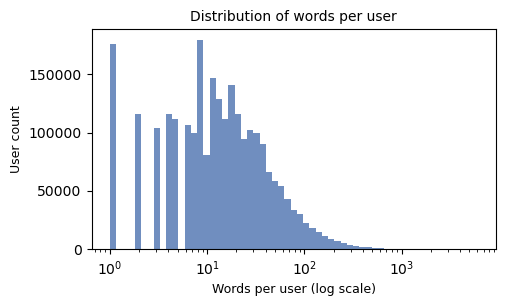

In [6]:

vals = df_nodes["n_words"].astype(float).to_numpy()
vals = vals[np.isfinite(vals)]

positive = vals[vals > 0]
bins = np.logspace(0, np.log10(positive.max()), 60)

plt.figure(figsize=(5,3))  # smaller figure
plt.hist(positive, bins=bins, color="#4c72b0", alpha=0.8, edgecolor="none")
plt.xscale("log")
plt.xlabel("Words per user (log scale)", fontsize=9)
plt.ylabel("User count", fontsize=9)
plt.title("Distribution of words per user", fontsize=10)
plt.tight_layout(pad=0.5)
plt.show()

The dataset shows realistic Reddit-like activity: around 100k users and 65M words.
Most users post very little (median = 31 words), while a few contribute heavily (avg ≈ 650 words, max ≈ 710k).
The histogram confirms a strong right-skew, typical of online forums where a small group generates most content.

In [7]:
# tokenize and clean text data

stop_words = set(stopwords.words('english'))

# extend basic english stopwords with slang terms
extra_stops = {
    'lol', 'xd', 'haha', 'hahaah', 'omg', 'u', 'ur', 'im', 'ive', 'idk', 
    'dont', 'cant', 'wont', 'aint', 'ya', 'tho', 'tho', 'nah', 'btw', 
    'like', 'yeah', 'yep', 'ok', 'okay', 'pls', 'please', 'get'
}
stop_words.update(extra_stops)

def preprocess_text(text):
    if not isinstance(text, str):
        return []
    # decode HTML entities: &amp; → &, &#x200B; → zero-width space, etc.
    text = html.unescape(text)
    # lowercase
    text = text.lower()
    # remove URLs
    text = re.sub(r"http\S+|www\S+", " ", text)
    # keep only letters and spaces
    text = re.sub(r"[^a-z\s]", " ", text)
    # tokenize by whitespace
    tokens = text.split()
    # remove stopwords and very short tokens
    tokens = [t for t in tokens if t not in stop_words and len(t) > 2]
    if len(tokens) == 1 and tokens[0] in {"removed", "deleted"}:
        return []
    return tokens

df_nodes["tokens"] = df_nodes["text"].apply(preprocess_text)
df_nodes["n_tokens"] = df_nodes["tokens"].apply(len)

df_nodes.head()


## Frequency-Rank-Plot

We will start by analysing our corpuses of product-descriptions for Zipf's law of abbreviation. This linguisic law states that the value of the n'th entry is inversly proportinal to n when token frequency is sorted in a list of decreasing order. This essentially means that the most common token in our corpus should occur twice as often as the next common one, three times as often as the third most common one and so on. We will check if this is the case in our corpuses by plotting the frequency of each token with the ideal zipf's law to compare:

In [8]:

# Flatten all tokens into one big list
all_tokens = [tok for tokens in df_nodes["tokens"] for tok in tokens]

# Count word frequencies
word_counts = Counter(all_tokens)

# Sort by frequency
sorted_counts = np.array(sorted(word_counts.values(), reverse=True))
ranks = np.arange(1, len(sorted_counts) + 1)

print(f"Total unique tokens: {len(word_counts):,}")
print(f"Most common words:\n{word_counts.most_common(10)}")


Total unique tokens: 337,976
Most common words:
[('women', 341259), ('people', 259035), ('would', 202161), ('even', 185868), ('one', 174173), ('men', 172137), ('think', 167166), ('know', 155508), ('want', 148246), ('good', 136779)]


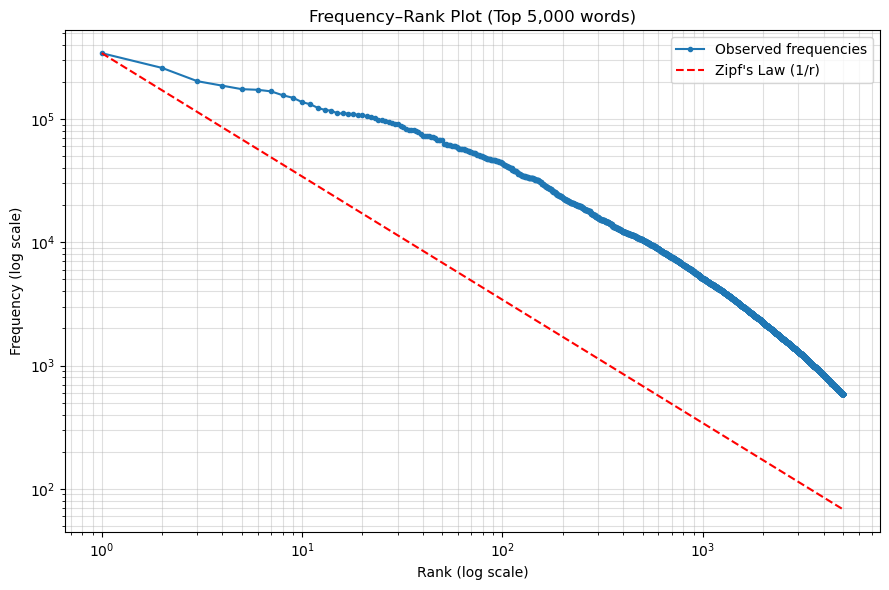

In [9]:

def plot_frequency_rank(tokens, top_n=5000):
    """
    Plot a Frequency–Rank (Zipf's Law) curve for a list of tokens.
    
    Parameters
    ----------
    tokens : list of str
        All tokens from your corpus.
    top_n : int
        Number of most frequent words to include in the plot.
    """
    # Count words
    word_counts = Counter(tokens)
    most_common = word_counts.most_common(top_n)
    freqs = np.array([f for _, f in most_common])
    ranks = np.arange(1, len(freqs) + 1)

    # Plot
    plt.figure(figsize=(9, 6))
    plt.plot(ranks, freqs, marker='o', markersize=3, linestyle='-', label='Observed frequencies')

    # Add Zipf’s Law reference line (theoretical expectation)
    constant = freqs[0]  # most frequent word
    zipf_line = constant / ranks
    plt.plot(ranks, zipf_line, linestyle='--', color='red', label="Zipf's Law (1/r)")

    # Log–log axes
    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel('Rank (log scale)')
    plt.ylabel('Frequency (log scale)')
    plt.title(f'Frequency–Rank Plot (Top {top_n:,} words)')
    plt.grid(True, which='both', alpha=0.4)
    plt.legend()
    plt.tight_layout()
    plt.show()

# --- Run it on your corpus ---
all_tokens = [tok for tokens in df_nodes["tokens"] for tok in tokens]
plot_frequency_rank(all_tokens, top_n=5000)

The curve mostly follows Zipf’s law, but it bends away from the ideal red line, which is normal for real online text.

This happens because:
- People on Reddit migth often repeat slang, memes, or usernames, making some words more frequent.
- The text might focuses on a few main topics, so certain words appear much more than in general language.
- Cleaning and removing stopwords change how rare words appear at the tail.

## TF-IDF scores and Wordclouds

Term Frequency–Inverse Document Frequency (TF-IDF) is a measure that highlights how important a word is within one document (or community) compared to the entire corpus.
- Term Frequency (TF): how often a word appears in a document.
- Inverse Document Frequency (IDF): how rare that word is across all documents.
- TF-IDF = TF × IDF: high when a word is frequent in one document but rare overall.
- TF–IDF is defined as:


$\text{TF–IDF} = \left( \frac{f_{i,j}}{\max_{k} f_{k,j}} \right) \times \log_2\left( \frac{N}{n_t} \right)$

where  
- $f_{t,d}$ is the frequency of term i in document j,  
- $max_{k} f_{k,j}$ is the maximum term frequency in document j,  
- N is the total number of documents, and  
- $n_i$ is the number of documents in which term i appears.

In this context:
- Each community is treated as a “document.”
- TF-IDF identifies keywords that are characteristic for each community, i.e. terms that distinguish that community’s language use from others.

In [10]:
# Combine all cleaned text within each community
community_texts = (
    df_nodes.groupby("community")["tokens"]
    .apply(lambda x: " ".join([" ".join(tokens) for tokens in x]))
    .reset_index()
)
community_texts.columns = ["community", "clean_text"]
community_texts.head()


In [11]:
print("Unique communities:", df_nodes['community'].nunique())
print("Total users:", len(df_nodes))
print(df_nodes['community'].value_counts().head(10))

Unique communities: 223
Total users: 2505905
community
130    644383
89     635828
129    630172
191    399843
220    154109
188     38490
206       372
42        330
197       272
67        258
Name: count, dtype: int64


In [12]:
community_tokens = (
    df_nodes
    .dropna(subset=['tokens', 'community'])
    .groupby('community', observed=True)['tokens']
    .apply(lambda groups: [tok for sublist in groups for tok in sublist])
    .reset_index()
)

community_tokens['n_tokens'] = community_tokens['tokens'].apply(len)
community_tokens['n_docs'] = df_nodes.groupby('community')['node_id'].count().values

community_tokens.head()
print(community_tokens.loc[community_tokens["community"] == 89])

    community                                             tokens  n_tokens  \
89         89  [care, girls, sex, open, surely, affect, comme...   7721869   

    n_docs  
89  635828  


In [13]:
# print amount of tokens and documents per community for the 10 largest communities
for idx, row in community_tokens.sort_values(by='n_tokens', ascending=False).head(10).iterrows():
    print(f"Community {row['community']} has {row['n_tokens']} tokens across {row['n_docs']} posts")



Community 130 has 8159749 tokens across 644383 posts
Community 89 has 7721869 tokens across 635828 posts
Community 129 has 6700663 tokens across 630172 posts
Community 191 has 4709952 tokens across 399843 posts
Community 188 has 1305336 tokens across 38490 posts
Community 220 has 1226959 tokens across 154109 posts
Community 206 has 4889 tokens across 372 posts
Community 213 has 2987 tokens across 30 posts
Community 67 has 1916 tokens across 258 posts
Community 186 has 1741 tokens across 96 posts


In [14]:

Top_6_communities = list(df_nodes['community'].value_counts().nlargest(6).index)

TF = {}
IDF = {}
TF_IDF = {}
top_users = {}   # top 3 users by token count
community_docs = {}

for c in Top_6_communities:
    # Documents in this community (each doc = one user's token list)
    docs_c = df_nodes.loc[df_nodes["community"] == c, ["node_id", "tokens"]].dropna(subset=["tokens"])
    tokens = [tok for token_list in docs_c["tokens"] for tok in token_list]
    community_docs[c] = tokens
    
df_global = Counter()
for c, toks in community_docs.items():
    df_global.update(set(toks))

N_docs = len(community_docs)

# Compute IDF (classical)
for tok, df in df_global.items():
    IDF[tok] = np.log(N_docs / df)

for c, toks in community_docs.items():

    term_freq = Counter(toks)
    max_freq = max(term_freq.values())  # For augmented TF

    # TF = freq / max_freq   (augmented TF)
    TF[c] = {tok: freq / max_freq for tok, freq in term_freq.items()}

    # Compute TF-IDF
    TF_IDF[c] = {
        tok: TF[c][tok] * IDF.get(tok, 0)
        for tok in TF[c].keys()
    }

for c in Top_6_communities:    
    # --- Print top TF-IDF terms ---
    top_TF_IDF = sorted(TF_IDF[c].items(), key=lambda x: x[1], reverse=True)[:20]
    print("\n-----------------------------------------------------------------------")
    print(f"Community {c} — top 20 TF-IDF terms")
    print("-----------------------------------------------------------------------")
    for token, score in top_TF_IDF:
        print(f"{token}\t{score:.4f}")

    # --- 4) Top 3 users by token count ---
    users_sorted = (
        docs_c.assign(n_tokens=lambda d: d["tokens"].apply(len))
              .sort_values("n_tokens", ascending=False)
              .loc[:, ["node_id", "n_tokens"]]
              .head(3)
    )

    # Convert node_id to native int for clean printing
    top_users[c] = [str(uid) for uid in users_sorted["node_id"].values]

    print("-----------------------------------------------------------------------")
    print(f"Top 3 high-volume users (by token count) in community {c}:")
    print("-----------------------------------------------------------------------")
    for uid, tokcount in zip(top_users[c], users_sorted["n_tokens"]):
        print(f"User ID: {uid} — tokens: {tokcount}")


-----------------------------------------------------------------------
Community 130 — top 20 TF-IDF terms
-----------------------------------------------------------------------
nrnr	0.0092
deletthis	0.0057
totesmessenger	0.0056
ignoreme	0.0047
eganwall	0.0028
gifv	0.0027
blacked	0.0023
helperbot	0.0022
concealed	0.0022
artursiedlecki	0.0015
hungicel	0.0014
nnlol	0.0014
numales	0.0013
nnnban	0.0013
editdeletereplynincels	0.0013
nyou	0.0012
npermalinksavecontextfull	0.0012
viewsn	0.0011
nbrooo	0.0010
isadeadgame	0.0010
-----------------------------------------------------------------------
Top 3 high-volume users (by token count) in community 130:
-----------------------------------------------------------------------
User ID: 32627 — tokens: 1146
User ID: 67444 — tokens: 947
User ID: 33513 — tokens: 939

-----------------------------------------------------------------------
Community 89 — top 20 TF-IDF terms
-----------------------------------------------------------------------
nh

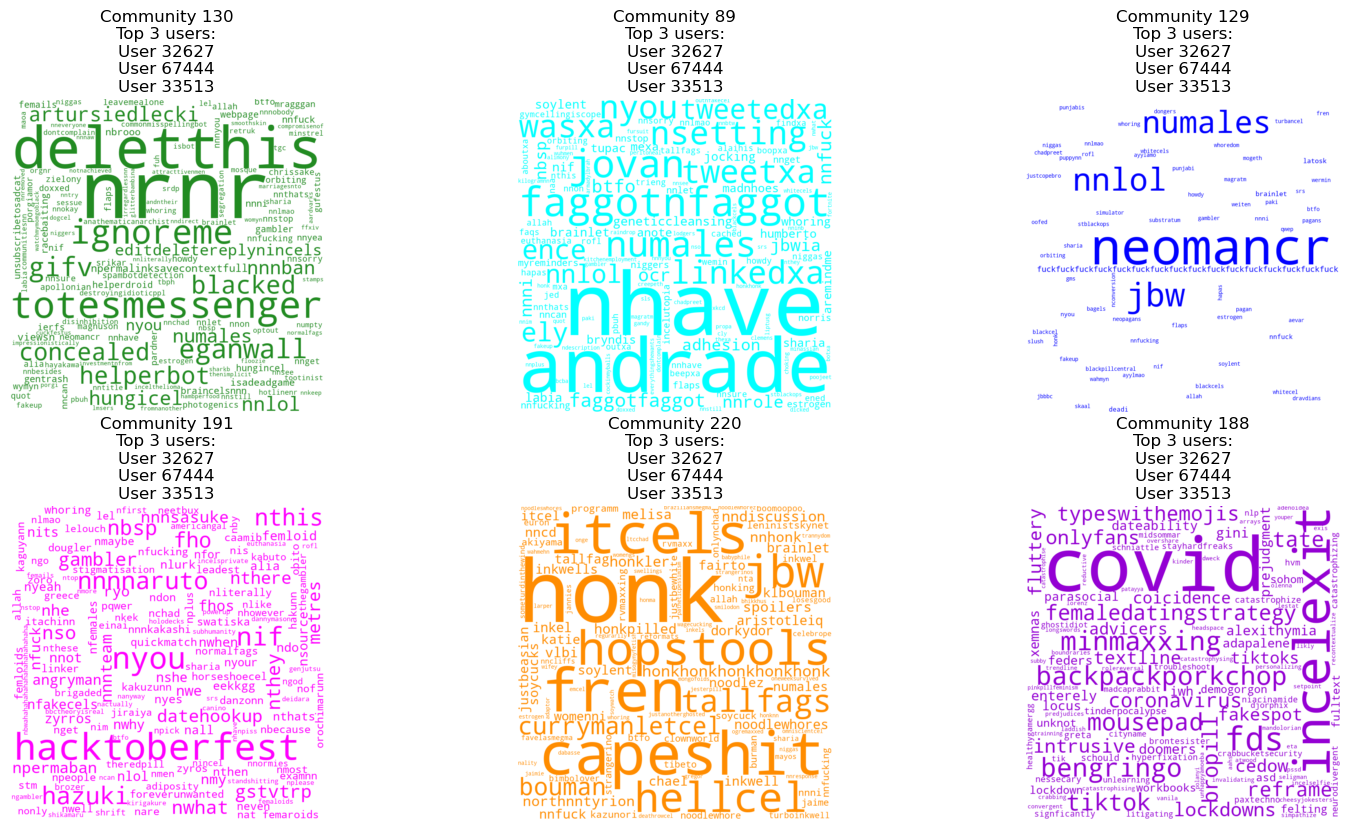

In [15]:
# Build top TF-IDF word lists and corresponding top users for display
top_tfidf_words = {}
Top_com_users = {}

for c in Top_6_communities:
    # top TF-IDF words for this community
    top_tfidf_words[c] = [
        word for word, score in sorted(TF_IDF[c].items(), key=lambda x: x[1], reverse=True)
    ]
    # top 3 users (already computed earlier)
    Top_com_users[c] = top_users.get(c, [])

colors = [ 'forestgreen', 'cyan', 'blue', 'magenta', 'darkorange', 'darkviolet']


def make_color_func(color):
    def _color_func(*args, **kwargs):
        return color 
    return _color_func

# --- 3x3 grid of subplots ---
fig, axs = plt.subplots(2, 3, figsize=(16, 8))
axs = axs.flatten()

for ax, c, color in zip(axs, Top_6_communities, colors):
    # generate word cloud from TF-IDF frequencies
    wordcloud = WordCloud(
        width=800,
        height=800,
        background_color='white',
        max_words = 150,
        min_font_size=14,
        prefer_horizontal=0.9,
        #colormap=cmap,
        margin=0
    ).generate_from_frequencies(TF_IDF[c])
    
    wordcloud.recolor(color_func=make_color_func(color))

    ax.imshow(wordcloud, interpolation='bilinear')
    # format top 3 users nicely for the title
    user_lines = "\n".join([f"User {uid}" for uid in Top_com_users[c]])
    ax.set_title(f"Community {c}\nTop 3 users:\n{user_lines}", fontsize=12)
    ax.axis('off')

# Remove empty subplots if fewer than 9 communities
for i in range(len(Top_6_communities), len(axs)):
    axs[i].axis('off')

plt.subplots_adjust(left=0.05, right=0.95, top=0.95, bottom=0.05, wspace=0.2, hspace=0.3)
#plt.subplots_adjust(wspace=0, hspace=0.3)
#plt.tight_layout(pad=0)
plt.show()

Initial results were unusual, with the classic IDF formula heavily penalizing words appearing in all communities and disproportionately highlighting extremely rare terms (perhaps appearing only once or twice in a single post). To address this imbalance, we introduced a smoother function for IDF calculation.  

In [16]:
# Compute IDF (smoothed)
for tok, df in df_global.items():
    IDF[tok] = np.log((1 + N_docs) / (1 + df)) + 0.02

for c, toks in community_docs.items():

    term_freq = Counter(toks)
    max_freq = max(term_freq.values())  # For augmented TF

    # TF = freq / max_freq   (augmented TF)
    TF[c] = {tok: freq / max_freq for tok, freq in term_freq.items()}

    # Compute TF-IDF
    TF_IDF[c] = {
        tok: TF[c][tok] * IDF.get(tok, 0)
        for tok in TF[c].keys()
    }

for c in Top_6_communities:    
    # --- Print top TF-IDF terms ---
    top_TF_IDF = sorted(TF_IDF[c].items(), key=lambda x: x[1], reverse=True)[:20]
    print("\n-----------------------------------------------------------------------")
    print(f"Community {c} — top 20 TF-IDF terms")
    print("-----------------------------------------------------------------------")
    for token, score in top_TF_IDF:
        print(f"{token}\t{score:.4f}")


-----------------------------------------------------------------------
Community 130 — top 20 TF-IDF terms
-----------------------------------------------------------------------
women	0.0200
people	0.0158
would	0.0117
even	0.0101
one	0.0100
men	0.0099
think	0.0098
know	0.0092
want	0.0087
incels	0.0075
good	0.0073
sex	0.0071
life	0.0070
incel	0.0070
nrnr	0.0066
really	0.0065
chad	0.0063
guys	0.0061
never	0.0061
fuck	0.0061

-----------------------------------------------------------------------
Community 89 — top 20 TF-IDF terms
-----------------------------------------------------------------------
women	0.0200
people	0.0143
would	0.0109
men	0.0100
even	0.0098
one	0.0097
think	0.0093
know	0.0088
want	0.0084
good	0.0073
fuck	0.0069
life	0.0068
incel	0.0064
sex	0.0062
guys	0.0062
incels	0.0061
really	0.0060
chad	0.0059
shit	0.0059
make	0.0058

-----------------------------------------------------------------------
Community 129 — top 20 TF-IDF terms
-----------------------------------

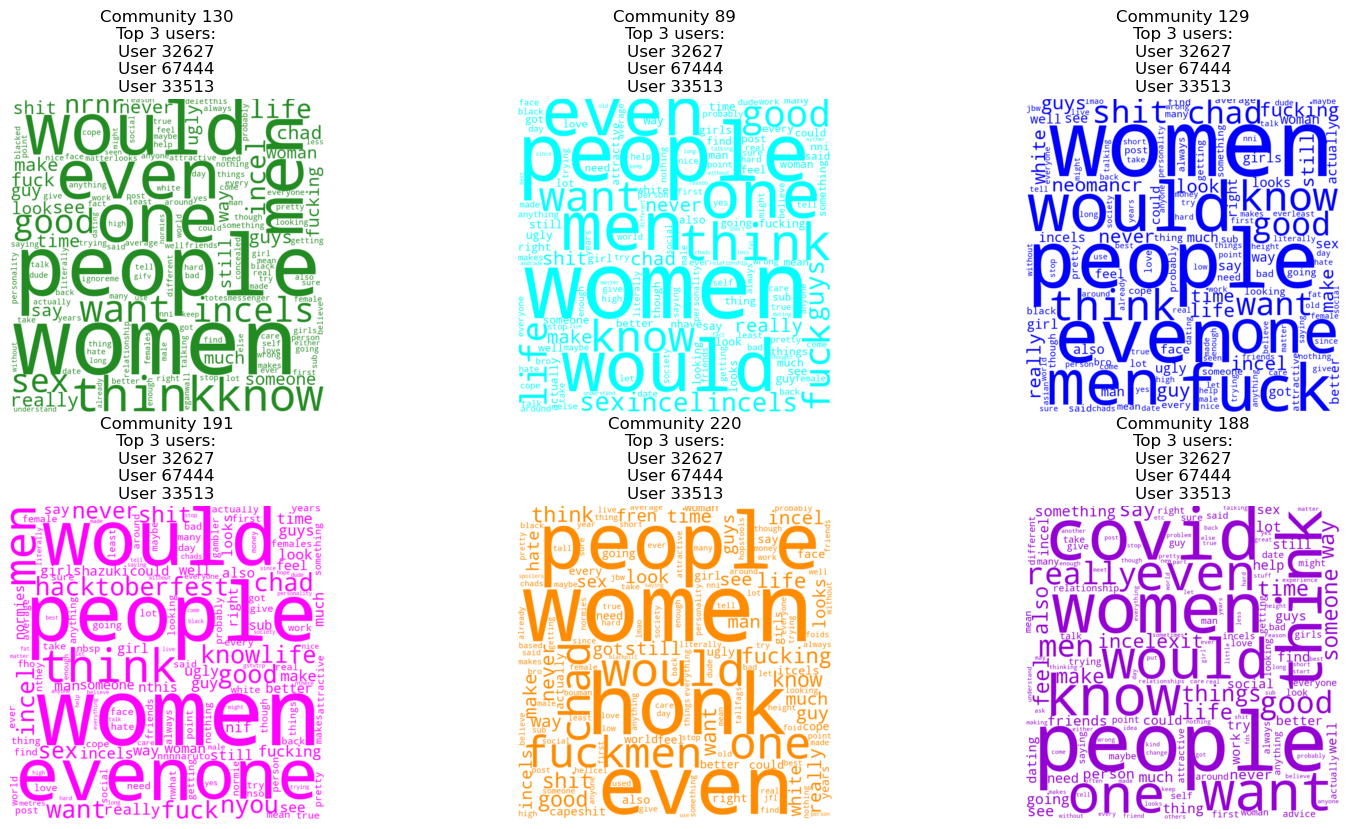

In [17]:

# --- 3x3 grid of subplots ---
fig, axs = plt.subplots(2, 3, figsize=(16, 8))
axs = axs.flatten()

for ax, c, color in zip(axs, Top_6_communities, colors):
    # generate word cloud from TF-IDF frequencies
    wordcloud = WordCloud(
        width=800,
        height=800,
        background_color='white',
        max_words = 150,
        min_font_size=14,
        prefer_horizontal=0.9,
        #colormap=cmap,
        margin=0
    ).generate_from_frequencies(TF_IDF[c])
    
    wordcloud.recolor(color_func=make_color_func(color))

    ax.imshow(wordcloud, interpolation='bilinear')
    # format top 3 users nicely for the title
    user_lines = "\n".join([f"User {uid}" for uid in Top_com_users[c]])
    ax.set_title(f"Community {c}\nTop 3 users:\n{user_lines}", fontsize=12)
    ax.axis('off')

# Remove empty subplots if fewer than 6 communities
for i in range(len(Top_6_communities), len(axs)):
    axs[i].axis('off')

plt.subplots_adjust(left=0.05, right=0.95, top=0.95, bottom=0.05, wspace=0.2, hspace=0.3)
#plt.subplots_adjust(wspace=0, hspace=0.3)
#plt.tight_layout(pad=0)
plt.show()



## Compare to sklearn prebuilt

In [18]:
from itertools import chain
# Aggregate all tokens per community into one long string
community_texts = (
    df_nodes.groupby("community")["tokens"]
            .apply(lambda token_lists: " ".join(chain.from_iterable(token_lists)))
            .reset_index()
)

community_texts.columns = ["community", "clean_text"]

# Take the top 6 most populated communities
Top_6_communities = list(
    df_nodes["community"].value_counts().nlargest(6).index
)
community_texts = community_texts[community_texts["community"].isin(Top_6_communities)]

community_texts.head()

In [19]:
vectorizer = TfidfVectorizer(
    stop_words=None,          # already cleaned
    max_features=3000,        # optional cap
    sublinear_tf=True,
    min_df= 1,#5,                 # ignore words appearing in <1 communities
    max_df= 1               # ignore very common words
)

X = vectorizer.fit_transform(community_texts["clean_text"])
feature_names = vectorizer.get_feature_names_out()
print(f"TF-IDF matrix shape: {X.shape}")


TF-IDF matrix shape: (6, 3000)


In [20]:

top_terms_sklearn = {}

for i, comm in enumerate(community_texts["community"]):
    row = X[i].toarray().flatten()
    top_idx = row.argsort()[-100:][::-1]
    top_terms_sklearn[comm] = dict(zip(feature_names[top_idx], row[top_idx]))

# --- Pretty print top words per community ---
for comm in community_texts["community"]:
    top_items = sorted(top_terms_sklearn[comm].items(), key=lambda x: x[1], reverse=True)[:20]
    
    print("\n" + "-"*70)
    print(f"Community {comm} — Top 20 TF-IDF terms (scikit-learn)")
    print("-"*70)
    print(f"{'Rank':<5}{'Word':<20}{'TF-IDF Score':>15}")
    print("-"*70)
    
    for rank, (word, score) in enumerate(top_items, start=1):
        print(f"{rank:<5}{word:<20}{score:>15.4f}")




----------------------------------------------------------------------
Community 89 — Top 20 TF-IDF terms (scikit-learn)
----------------------------------------------------------------------
Rank Word                   TF-IDF Score
----------------------------------------------------------------------
1    andrade                      0.0816
2    faggotnfaggot                0.0772
3    jovan                        0.0764
4    nsetting                     0.0711
5    tweetedxa                    0.0706
6    tweetxa                      0.0706
7    linkedxa                     0.0706
8    wasxa                        0.0706
9    ence                         0.0704
10   ely                          0.0697
11   faggotfaggot                 0.0687
12   adhesion                     0.0635
13   mexa                         0.0619
14   bryndis                      0.0619
15   madnhoes                     0.0611
16   trieng                       0.0581
17   jed                          0.057

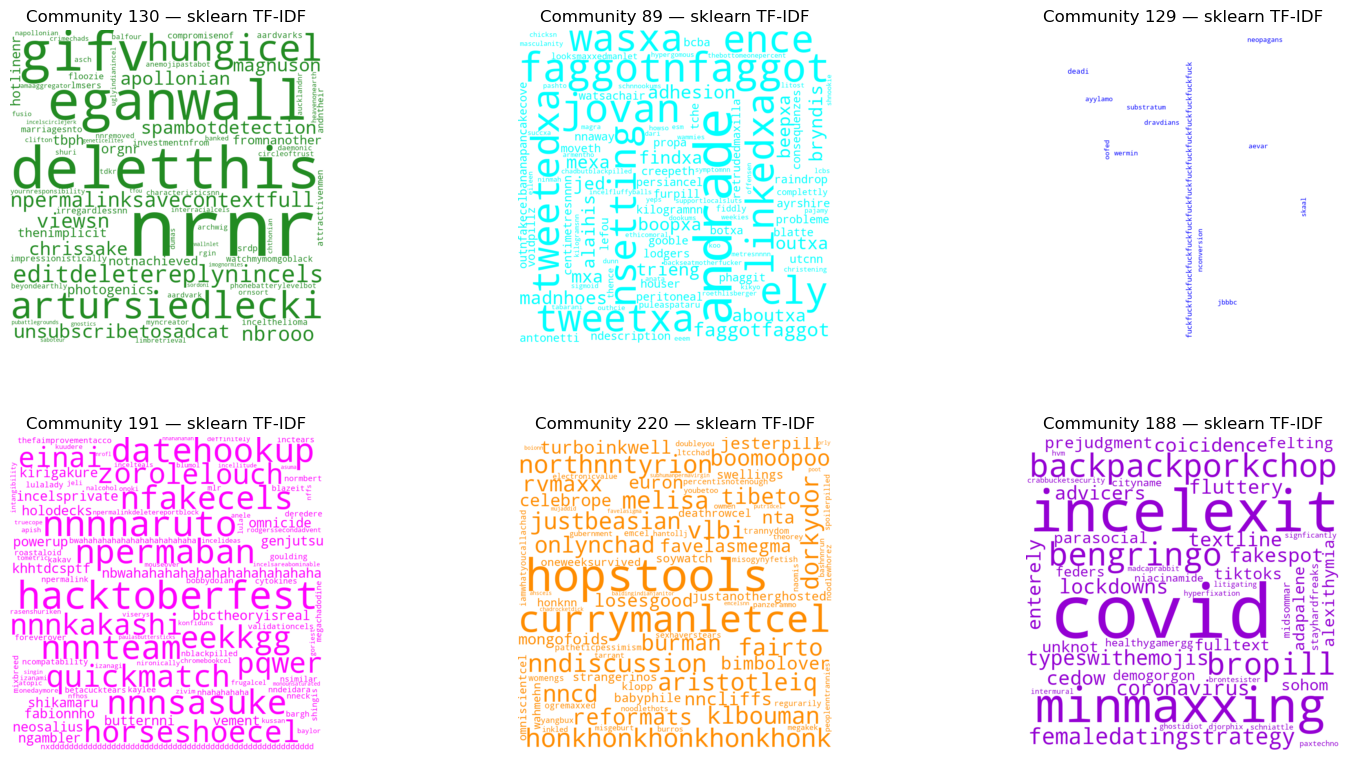

In [21]:

fig, axs = plt.subplots(2, 3, figsize=(16, 8))
axs = axs.flatten()

for ax, c, color in zip(axs, Top_6_communities, colors):
    words = top_terms_sklearn.get(c, {})
    
    # --- Fix 1: Replace NaNs/Infs and remove zero values ---
    clean_words = {k: float(v) for k, v in words.items() if np.isfinite(v) and v > 0}
    
    if not clean_words:
        ax.axis("off")
        continue

    # --- Fix 2: Normalize frequencies to avoid large-scale differences ---
    max_val = max(clean_words.values())
    clean_words = {k: v / max_val for k, v in clean_words.items()}

    wc = WordCloud(
        width=800,
        height=800,
        max_words=150,
        background_color="white",
        #colormap=cmap,
        min_font_size=14,
        prefer_horizontal=0.9,
        margin=0
    ).generate_from_frequencies(clean_words)
    
    wc.recolor(color_func=make_color_func(color))
    
    ax.imshow(wc, interpolation="bilinear")
    ax.set_title(f"Community {c} — sklearn TF-IDF", fontsize=12)
    ax.axis("off")

# Turn off unused subplots
for i in range(len(Top_6_communities), len(axs)):
    axs[i].axis("off")

plt.subplots_adjust(left=0.05, right=0.95, top=0.95, bottom=0.05, wspace=0.2, hspace=0.3)
plt.show()
